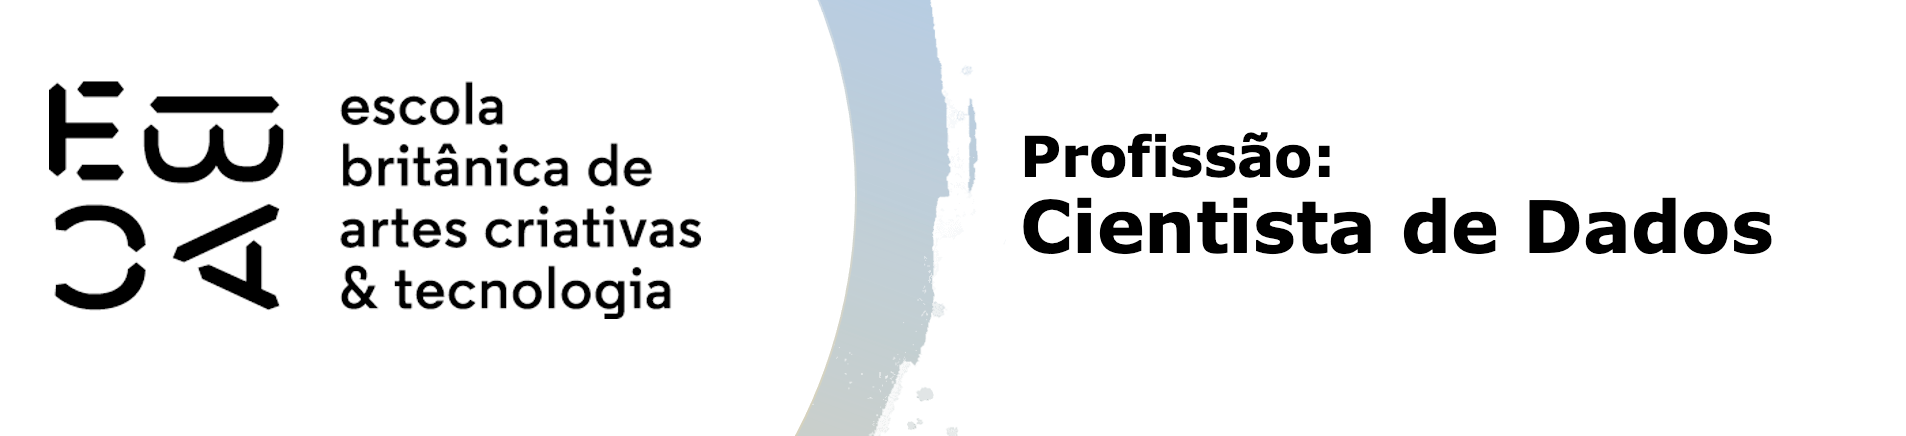

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import warnings

from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import r2_score
from scipy.stats import ks_2samp
from scipy.stats import t

pd.set_option('mode.chained_assignment', None)

warnings.simplefilter(action = 'ignore', category = FutureWarning)

df_original = pd.read_feather('credit_scoring.ftr')
df_original.head(3)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False


In [2]:
# Tamanho do dataframe

df_original.shape

(750000, 15)

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
# Validação out of time

df_oot = df_original[df_original['data_ref'] >= '2016-03-01 00:00:00']

df_oot.head(3)

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
700000,2016-03-01,3422,F,N,S,0,Assalariado,Superior completo,Casado,Casa,57,13.194521,2.0,10056.83,False
700001,2016-03-01,4646,M,N,N,0,Assalariado,Médio,União,Casa,45,0.605479,2.0,622.91,False
700002,2016-03-01,6554,F,N,S,0,Assalariado,Superior completo,Casado,Casa,43,4.156164,2.0,1503.62,False


In [4]:
# Tamanho do dataframe de validação

df_oot.shape

(50000, 15)

In [5]:
# Cópia para não perder os dados originais

df = df_original.copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
f'Número total de linhas: {len(df)}'

'Número total de linhas: 750000'

In [7]:
# Entendendo a distribuição dos dados por tempo

df.groupby([df['data_ref'].dt.year, df['data_ref'].dt.month]).size()

data_ref  data_ref
2015      1           50000
          2           50000
          3           50000
          4           50000
          5           50000
          6           50000
          7           50000
          8           50000
          9           50000
          10          50000
          11          50000
          12          50000
2016      1           50000
          2           50000
          3           50000
dtype: int64

In [8]:
# Entendendo a distribuição da variável resposta

df['mau'].value_counts(normalize = True)*100

mau
False    92.180933
True      7.819067
Name: proportion, dtype: float64

_A Análise descritiva univariada está disponível no [app do Streamlit](https://perfil-renda.streamlit.app/)._

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

_A Análise descritiva bivariada também está disponível no [app do Streamlit](https://perfil-renda.streamlit.app/)._

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [9]:
# Usando os dados da Análise bivariada, percebemos uma relação muito forte entre 'qtd_filhos' e 'qt_pessoas_residencia'
# Por isso, vamos eliminar 'qt_pessoas_residencia' já que tem vários outliers

df.drop(columns = 'qt_pessoas_residencia', inplace = True)

In [10]:
# Checando por missings

df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego       125957
renda                    0
mau                      0
dtype: int64

In [11]:
# Entendendo de onde vem os missings

pd.crosstab(df['tempo_emprego'].isna(), df['tipo_renda'], margins=True)

tipo_renda,Assalariado,Bolsista,Empresário,Pensionista,Servidor público,All
tempo_emprego,,,,,,
False,385740,361,172712,308,64922,624043
True,0,0,0,125957,0,125957
All,385740,361,172712,126265,64922,750000


In [12]:
# Ao perceber que todos os missings se concentram nos Pensionistas (que realmente não trabalham), vamos preencher esses
# missings com a flag -1

df['tempo_emprego'].fillna(-1, inplace=True)

In [13]:
# Confirmando as alterações

df.isna().sum()

data_ref            0
index               0
sexo                0
posse_de_veiculo    0
posse_de_imovel     0
qtd_filhos          0
tipo_renda          0
educacao            0
estado_civil        0
tipo_residencia     0
idade               0
tempo_emprego       0
renda               0
mau                 0
dtype: int64

In [14]:
# Definindo criação de gráficos para cada coluna

def biv_discreta(var, df):
    df.loc[:, 'bom'] = 1 - df['mau']  
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [15]:
# Verificando zeros estruturais entre 'mau' e as variáveis categóricas

categoricas = df.select_dtypes(include=['object', 'category']).columns

for col in categoricas:
    if col != 'mau':
        crosstab = pd.crosstab(df[col], df['mau'], margins=True, margins_name="Total")
        print(f"Tabela cruzada entre '{col}' e 'mau':")
        print(crosstab)
        print("\n")

Tabela cruzada entre 'sexo' e 'mau':
mau     False   True   Total
sexo                        
F      463950  40630  504580
M      227407  18013  245420
Total  691357  58643  750000


Tabela cruzada entre 'posse_de_veiculo' e 'mau':
mau                False   True   Total
posse_de_veiculo                       
N                 421872  36082  457954
S                 269485  22561  292046
Total             691357  58643  750000


Tabela cruzada entre 'posse_de_imovel' e 'mau':
mau               False   True   Total
posse_de_imovel                       
N                224515  21793  246308
S                466842  36850  503692
Total            691357  58643  750000


Tabela cruzada entre 'tipo_renda' e 'mau':
mau                False   True   Total
tipo_renda                             
Assalariado       354527  31213  385740
Bolsista             346     15     361
Empresário        159508  13204  172712
Pensionista       115825  10440  126265
Servidor público   61151   3771   649

In [16]:
# Não temos zeros estruturais

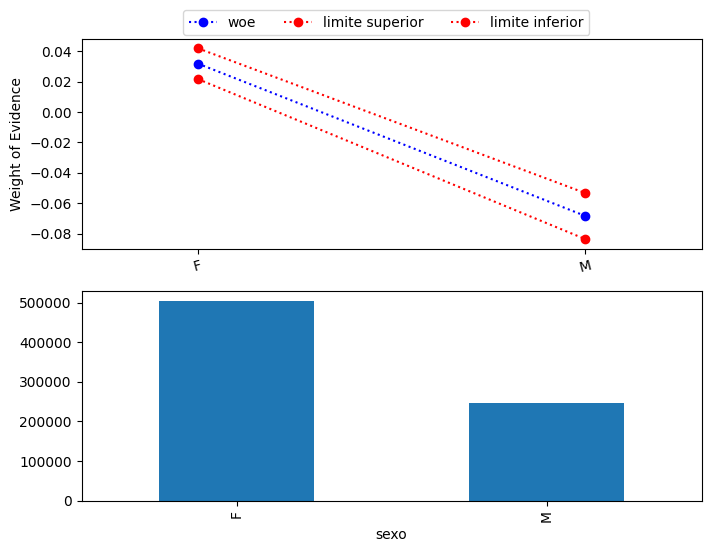

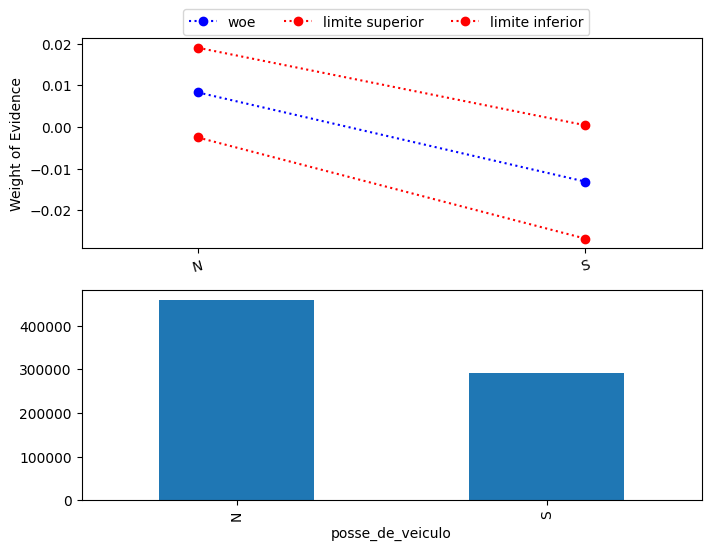

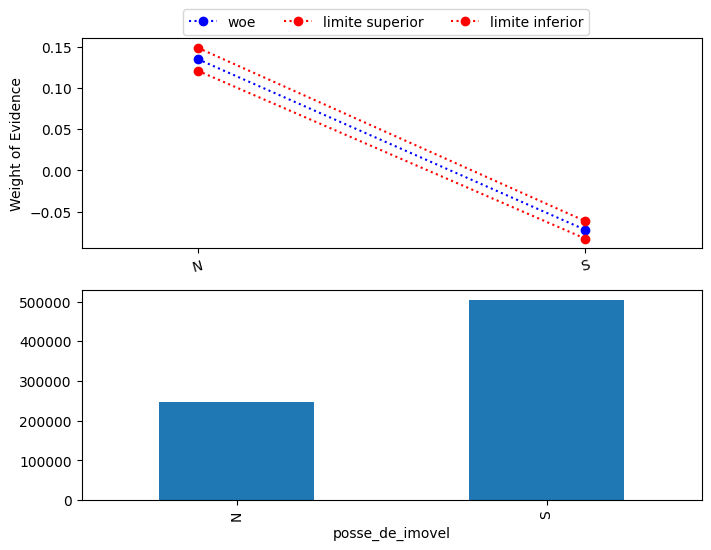

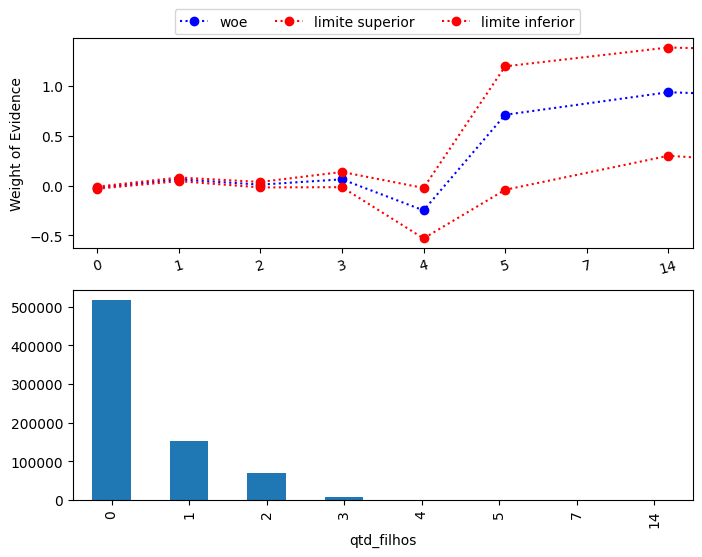

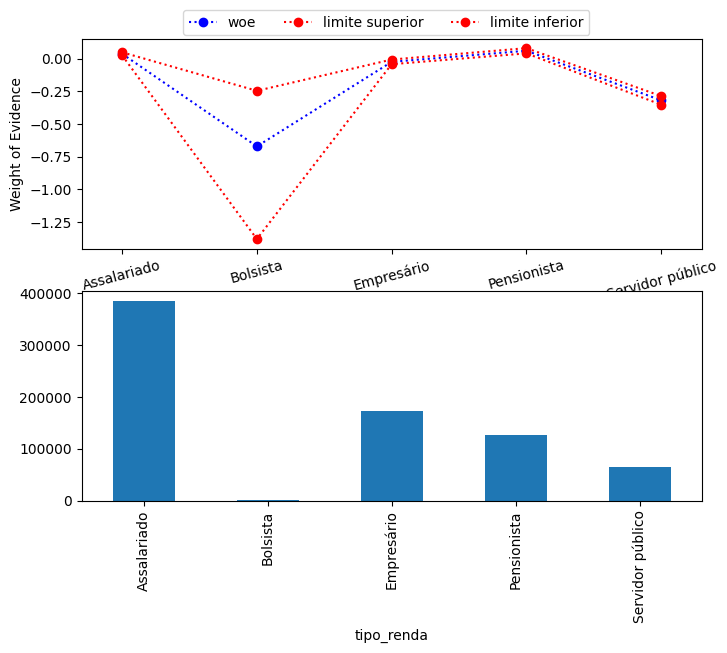

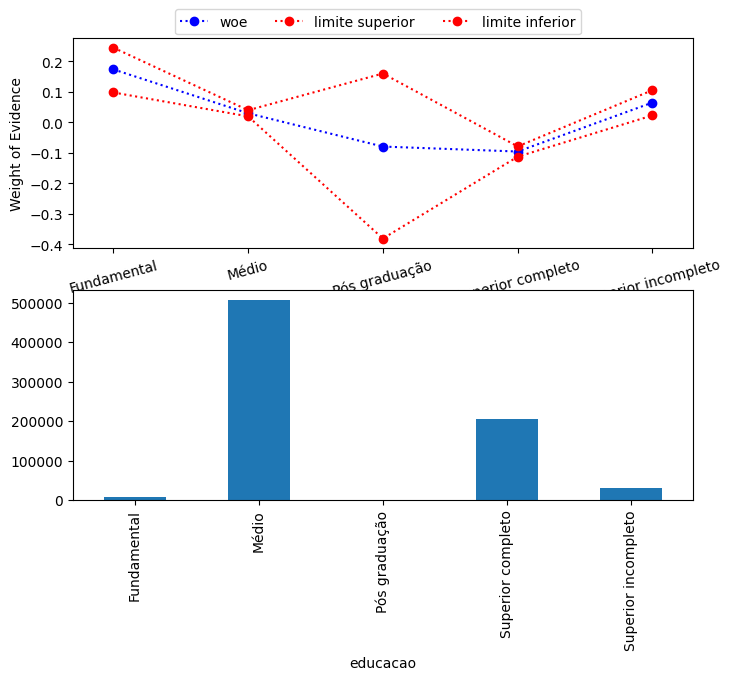

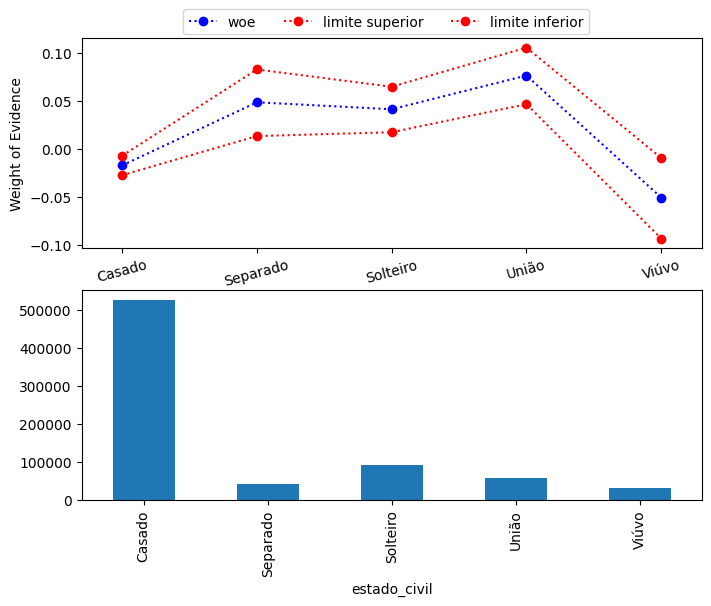

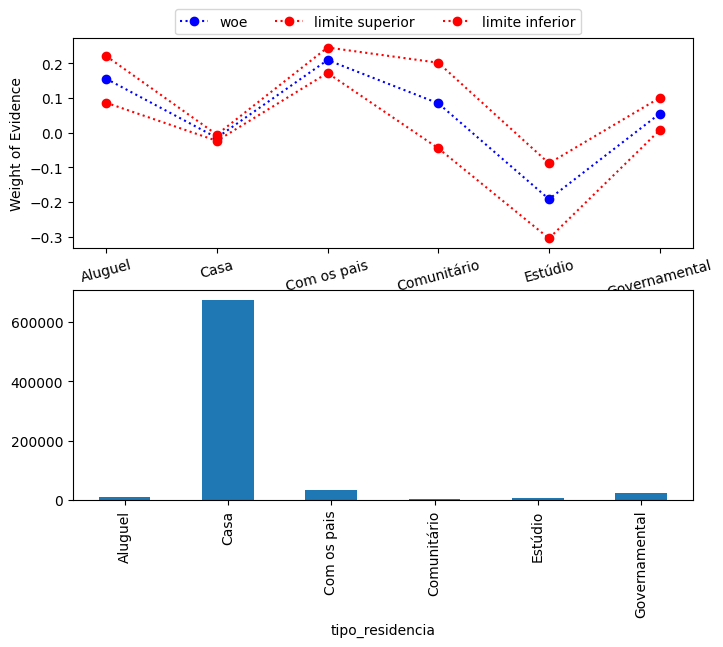

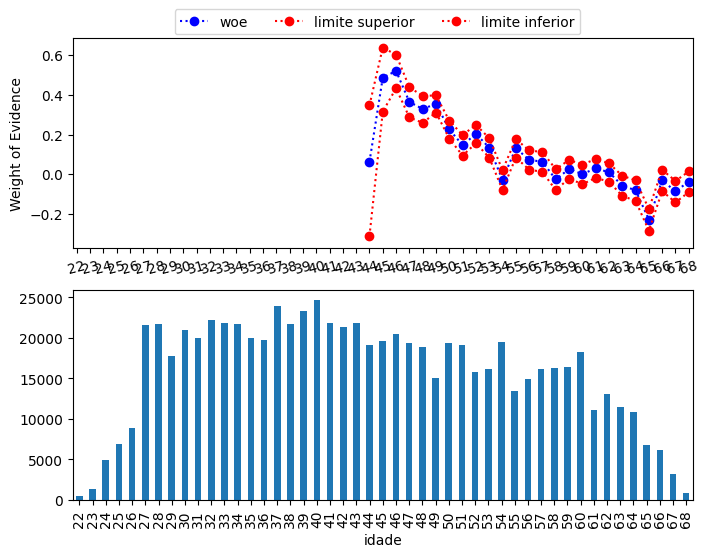

In [17]:
# Vamos analisar os WOEs e juntar categorias similares

for var in df.columns:
     if var not in ['data_ref', 'index', 'tempo_emprego', 'renda', 'bom', 'mau']:
        biv_discreta(var, df)

In [18]:
# Iniciando as substituições necessárias:

In [19]:
df.tipo_renda.replace({'Bolsista': 'Bolsista/ Serv. Públ.', 'Servidor público': 'Bolsista/ Serv. Públ.'}, inplace=True)

In [20]:
df.qtd_filhos.replace({4: 'Mais de 4 filhos', 5: 'Mais de 4 filhos',
                       7: 'Mais de 4 filhos', 14: 'Mais de 4 filhos',}, inplace=True)
df['qtd_filhos'] = df['qtd_filhos'].astype(str)

In [21]:
df.educacao.replace({'Fundamental': 'Ensino Básico', 'Médio': 'Ensino Básico', 'Pós graduação' : 'Superior completo'},
                      inplace=True)

In [22]:
df.estado_civil.replace({'Casado': 'Casado/ União Estável', 'União': 'Casado/ União Estável', 
                         'Separado' : 'Separado/ Viúvo', 'Viúvo' : 'Separado/ Viúvo'}, inplace=True)

In [23]:
df.tipo_residencia.replace({'Comunitário': 'Comunit./ Gov.', 'Governamental': 'Comunit./ Gov.', 'Casa' : 'Casa própria',
                         'Estúdio' : 'Casa própria', 'Aluguel' : 'Com os pais/ Aluguel', 
                         'Com os pais' : 'Com os pais/ Aluguel'}, inplace=True)

In [24]:
# Criando metadados e calculando IV

metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados.drop(['data_ref', 'index'], inplace = True)
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)
    
metadados.sort_values('IV', ascending = False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0,142419,covariavel,1.068628
tempo_emprego,float64,0,3005,covariavel,0.265434
idade,int64,0,47,covariavel,0.017968
posse_de_imovel,object,0,2,covariavel,0.009693
tipo_renda,object,0,4,covariavel,0.009315
educacao,object,0,3,covariavel,0.003296
tipo_residencia,object,0,3,covariavel,0.002802
sexo,object,0,2,covariavel,0.002185
qtd_filhos,object,0,5,covariavel,0.001209
estado_civil,object,0,3,covariavel,0.000263


In [25]:
# Realizando as mudanças no DataFrame oot

df_oot = df.loc[df['data_ref'] >= '2016-03-01']

df_oot.head(3)

df = df[~df.index.isin(df_oot.index)]

In [26]:
# Criando equação para a Regressão

"', '".join(list(metadados.sort_values(by='IV', ascending=False).index))

"renda', 'tempo_emprego', 'idade', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'sexo', 'qtd_filhos', 'estado_civil', 'posse_de_veiculo', 'mau', 'bom"

In [27]:
# Criando DataFrame com as variáveis mais importantes e transformando em dummies

df_rl = df[['renda', 'tempo_emprego', 'idade', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'sexo']]

df_rl = pd.get_dummies(df_rl)

In [28]:
# Criando e fitando a Regressão Logística

rl = LogisticRegression(class_weight = {0: 1, 1: 8}, random_state = 42, max_iter = 1000000).fit(df_rl, df['mau'])

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [29]:
# Fazendo a predição na base de desenvolvimento

df_rl['score'] = rl.predict(df_rl)

In [30]:
# Calculando a eficiência do modelo

# Acurácia
df_rl['score'] = (df_rl['score'] > 0.5).astype(int)  
acc = metrics.accuracy_score(df.mau, df_rl.score)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df.mau, df_rl.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1

# KS
ks = ks_2samp(df_rl['score'][df['mau'] == 1], df_rl['score'][df['mau'] != 1]).statistic

print(f'Acurácia: {acc} \nAUC: {auc} \nGINI: {gini}\nKS: {ks}')

Acurácia: 0.7746314285714285 
AUC: 0.6897132373215751 
GINI: 0.37942647464315016
KS: 0.37942647464315005


In [31]:
# Calculando a eficiência do modelo na base oot

df_oot_rl = df_oot[['renda', 'tempo_emprego', 'idade', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'sexo']]

df_oot_rl = pd.get_dummies(df_oot_rl)

df_oot_rl['score'] = rl.predict(df_oot_rl)

# Acurácia
df_oot_rl['score'] = (df_oot_rl['score'] > 0.5).astype(int)  
acc = metrics.accuracy_score(df_oot.mau, df_oot_rl.score)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot_rl.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1

# KS
ks = ks_2samp(df_oot_rl['score'][df_oot['mau'] == 1], df_oot_rl['score'][df_oot['mau'] != 1]).statistic

print(f'Acurácia: {acc} \nAUC: {auc} \nGINI: {gini}\nKS: {ks}')

Acurácia: 0.52128 
AUC: 0.6449270051018008 
GINI: 0.2898540102036016
KS: 0.2898540102036017


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

_Conforme o estudo acima, os missings estão todos concentrados em tempo_emprego._  
_Escolhi substituir esses missings usando a flag -1 para que o modelo entenda que é uma categoria separada das outras: pessoas que não trabalham, porém tem renda e são Pensionistas._

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

_Preferi não remover outliers nesse DataFrame porque acredito que os outliers também farão parte das análises futuras._

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

_Conforme evidenciado acima, usei o IV para selecionar as variáveis mais importantes._

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

_Acredito que retirar mais 3 variáveis pode tirar o poder de decisão do modelo, por isso preferi não realizar essa etapa._

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

_Foi aplicado em todas as variáveis seleciondas para fazer parte do modelo._

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [33]:
# Criação do Pipeline com todas as funções acima

# Configurações iniciais

pd.set_option('mode.chained_assignment', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Carregando os dados

def load_data(file_path):

    df_original = pd.read_feather(file_path)
    df = df_original.copy()
    
    return df_original, df

# 2. Preparando os dados

def preprocess_data(df):

    # Substituindo missings
    
    df['tempo_emprego'].fillna(-1, inplace=True)
   
    # Removendo coluna desnecessária
    
    if 'qt_pessoas_residencia' in df.columns:
        df.drop(columns=['qt_pessoas_residencia'], inplace=True)

    # Recategorizando
    
    df.tipo_renda.replace({'Bolsista': 'Bolsista/ Serv. Públ.', 'Servidor público': 'Bolsista/ Serv. Públ.'}, 
                          inplace=True)
    df.qtd_filhos.replace({4: 'Mais de 4 filhos', 5: 'Mais de 4 filhos', 7: 'Mais de 4 filhos', 14: 'Mais de 4 filhos'}, 
                          inplace=True)
    df['qtd_filhos'] = df['qtd_filhos'].astype(str)
    df.educacao.replace({'Fundamental': 'Ensino Básico', 'Médio': 'Ensino Básico', 'Pós graduação' : 'Superior completo'},
                      inplace=True)
    df.estado_civil.replace({'Casado': 'Casado/ União Estável', 'União': 'Casado/ União Estável', 
                         'Separado' : 'Separado/ Viúvo', 'Viúvo' : 'Separado/ Viúvo'}, inplace=True)
    df.tipo_residencia.replace({'Comunitário': 'Comunit./ Gov.', 'Governamental': 'Comunit./ Gov.', 
                                'Casa' : 'Casa própria', 'Estúdio' : 'Casa própria', 'Aluguel' : 'Com os pais/ Aluguel',
                                'Com os pais' : 'Com os pais/ Aluguel'}, inplace=True)

    return df

# 3. Separando dados em treinamento e out-of-time (OOT)

def split_data(df, oot_date):
    
    df_oot = df[df['data_ref'] >= oot_date].copy()
    df = df[~df.index.isin(df_oot.index)]    
    
    return df, df_oot

# 4. Criando DataFrame com as variáveis mais importantes e transformando em dummies

def create_features(df):
  
    df_rl = df[['renda', 'tempo_emprego', 'idade', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'sexo']]
    df_rl = pd.get_dummies(df_rl)

    return df_rl

# 5. Avaliação do modelo

def evaluate_model(model, X, y):
    
    X['score'] = model.predict(X)

    # Acurácia
    X['score'] = (X['score'] > 0.5).astype(int)  
    acc = metrics.accuracy_score(y, X.score)

    #AUC
    fpr, tpr, thresholds = metrics.roc_curve(y, X.score)
    auc = metrics.auc(fpr, tpr)

    #Gini
    gini = 2*auc -1

    # KS
    ks = ks_2samp(X['score'][y == 1], X['score'][y != 1]).statistic

    print_acc = print(f'Acurácia: {acc} \nAUC: {auc} \nGINI: {gini}\nKS: {ks}')

    return print_acc

if __name__ == "__main__":
    
    # Carregar dados
    df_original, df = load_data('credit_scoring.ftr')

    # Dividir os dados
    df, df_oot = split_data(df, '2016-03-01')

    # Definir a pipeline
    pipeline = Pipeline([
        ("preprocess", FunctionTransformer(preprocess_data)),
        ("feature_creation", FunctionTransformer(create_features)),
        ("model", LogisticRegression(class_weight={0: 1, 1: 8}, random_state=42, max_iter=1000000))
    ])

    # Variável alvo
    y_train = df['mau']
    y_test = df_oot['mau']

    # Treinar o modelo com a pipeline
    pipeline.fit(df, y_train)

    # Avaliar o modelo no conjunto de treino
    print('Eficiência no treino:')
    evaluate_model(pipeline.named_steps["model"], create_features(preprocess_data(df)), y_train)
    
    print('---')

    # Avaliar o modelo no conjunto OOT
    print('Eficiência no teste:')
    evaluate_model(pipeline.named_steps["model"], create_features(preprocess_data(df_oot)), y_test)

Eficiência no treino:
Acurácia: 0.7746314285714285 
AUC: 0.6897132373215751 
GINI: 0.37942647464315016
KS: 0.37942647464315005
---
Eficiência no teste:
Acurácia: 0.52128 
AUC: 0.6449270051018008 
GINI: 0.2898540102036016
KS: 0.2898540102036017


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [34]:
# Importando o pycaret

from pycaret.classification import *

In [35]:
# Criando a base do modelo

modelo = setup(data = df, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(700000, 14)"
4,Transformed data shape,"(700000, 29)"
5,Transformed train set shape,"(489999, 29)"
6,Transformed test set shape,"(210001, 29)"
7,Numeric features,4
8,Date features,1
9,Categorical features,8


In [36]:
# Testando melhor modelo

best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9284,0.7766,0.0187,0.5582,0.0360,0.0314,0.0891,16.2420
gbc,Gradient Boosting Classifier,0.9284,0.7775,0.0169,0.5397,0.0329,0.0286,0.0860,51.8320
lightgbm,Light Gradient Boosting Machine,0.9284,0.7764,0.0189,0.5260,0.0364,0.0316,0.0893,15.1920
lr,Logistic Regression,0.9282,0.7685,0.0000,0.0000,0.0000,0.0000,0.0000,34.6440
ridge,Ridge Classifier,0.9282,0.6758,0.0000,0.0000,0.0000,0.0000,0.0000,3.6100
lda,Linear Discriminant Analysis,0.9282,0.6758,0.0000,0.0000,0.0000,0.0000,0.0000,4.6000
xgboost,Extreme Gradient Boosting,0.9282,0.7709,0.0213,0.4930,0.0409,0.0351,0.0910,10.1160
dummy,Dummy Classifier,0.9282,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,3.9540
catboost,CatBoost Classifier,0.9277,0.7711,0.0274,0.4426,0.0515,0.0435,0.0959,97.1460
knn,K Neighbors Classifier,0.9215,0.6324,0.0620,0.2851,0.1018,0.0782,0.1040,170.1320


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [37]:
# Vendo qual o modelo mais indicado

print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)


In [38]:
# Criando o Light Gradient Boosting Machine conforme pedido

lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9285,0.7753,0.0202,0.5462,0.0389,0.0340,0.0948
1,0.9286,0.7769,0.0179,0.5676,0.0347,0.0305,0.0915
2,0.9284,0.7770,0.0165,0.5472,0.0320,0.0279,0.0858
3,0.9283,0.7804,0.0191,0.5038,0.0367,0.0317,0.0873
4,0.9283,0.7737,0.0171,0.5128,0.0330,0.0285,0.0836
5,0.9283,0.7832,0.0142,0.5102,0.0277,0.0239,0.0760
6,0.9281,0.7785,0.0159,0.4746,0.0308,0.0263,0.0767
7,0.9282,0.7789,0.0179,0.4884,0.0346,0.0296,0.0829
8,0.9285,0.7743,0.0191,0.5537,0.0368,0.0322,0.0929


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
# Tunando o modelo

tuned_lightgbm = tune_model(lightgbm, fold = 3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9285,0.7739,0.0166,0.5640,0.0322,0.0282,0.0876
1,0.9283,0.7747,0.0203,0.5085,0.0391,0.0337,0.0907
2,0.9283,0.7718,0.0200,0.5098,0.0386,0.0333,0.0903
Mean,0.9284,0.7735,0.0190,0.5274,0.0366,0.0317,0.0895
Std,0.0001,0.0012,0.0017,0.0258,0.0031,0.0025,0.0014


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


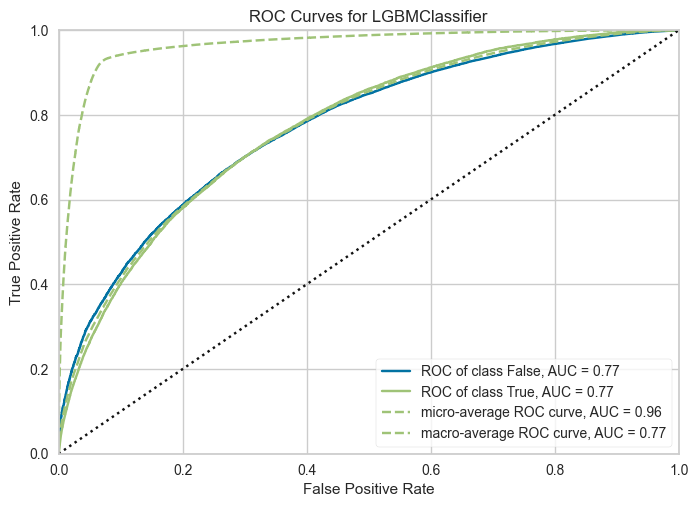

In [40]:
# Gráficos para estudo do modelo

plot_model(tuned_lightgbm, plot = 'auc')

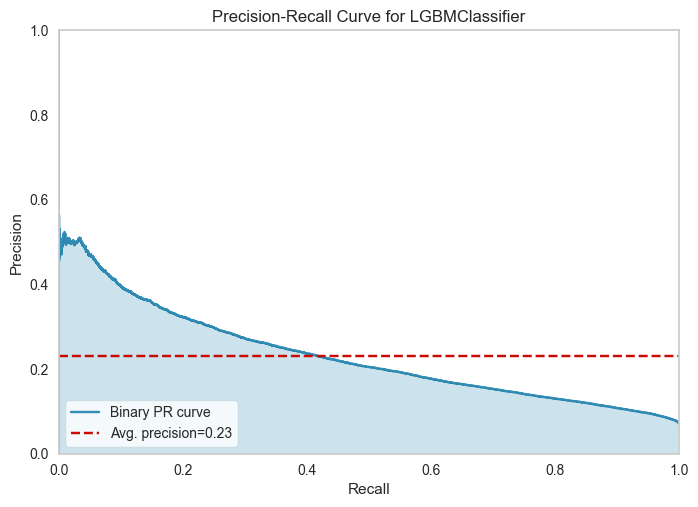

In [41]:
plot_model(tuned_lightgbm, plot = 'pr')

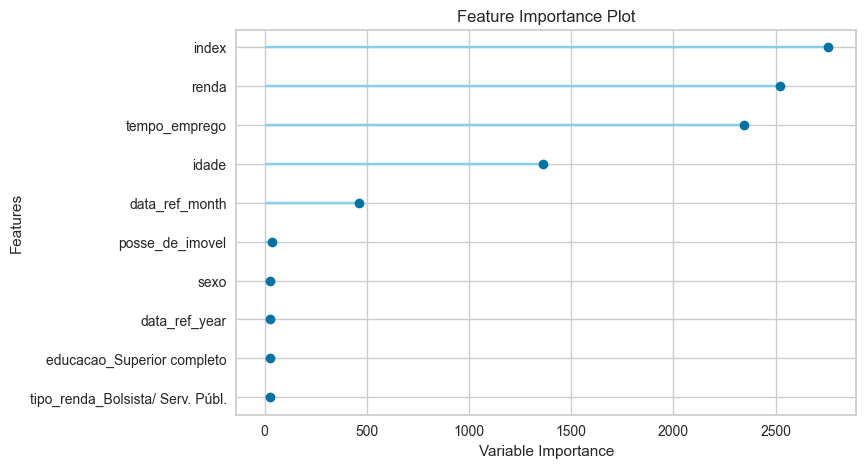

In [42]:
# Importância das variáveis

plot_model(tuned_lightgbm, plot='feature')

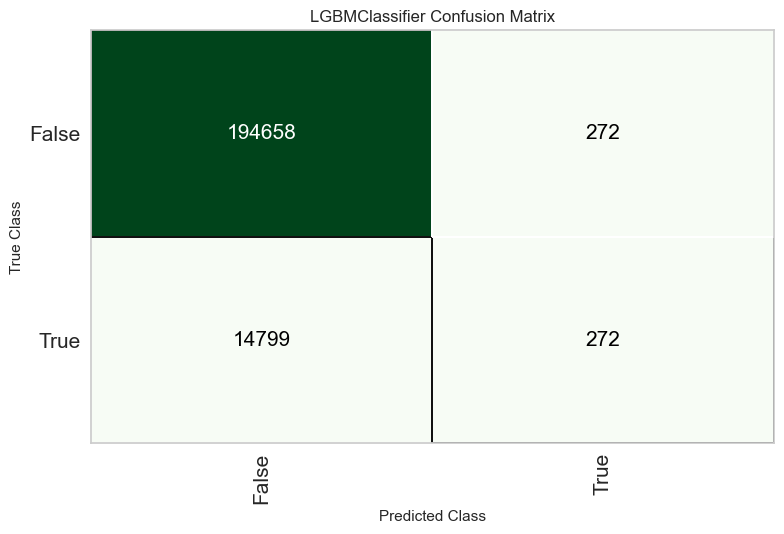

In [43]:
# Matriz de Confusão

plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [44]:
# Finalizando o modelo

final_lightgbm = finalize_model(tuned_lightgbm)

In [45]:
# Vendo as métricas do modelo no treino

predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9285,0.7891,0.0190,0.5650,0.0368,0.0323,0.0941


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [46]:
# E na base oot

predict_model(final_lightgbm, data = df_oot)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8324,0.7283,0.0456,0.5190,0.0838,0.0582,0.1148


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,renda,mau,prediction_label,prediction_score
700000,2016-03-01,3422,F,N,S,0,Assalariado,Superior completo,Casado/ União Estável,Casa própria,57,13.194521,10056.830078,False,0,0.9524
700001,2016-03-01,4646,M,N,N,0,Assalariado,Ensino Básico,Casado/ União Estável,Casa própria,45,0.605479,622.909973,False,0,0.6396
700002,2016-03-01,6554,F,N,S,0,Assalariado,Superior completo,Casado/ União Estável,Casa própria,43,4.156164,1503.619995,False,0,0.7724
700003,2016-03-01,16278,F,S,S,3,Assalariado,Ensino Básico,Casado/ União Estável,Casa própria,38,10.967123,15680.530273,False,0,0.9703
700004,2016-03-01,12890,F,N,N,0,Assalariado,Ensino Básico,Casado/ União Estável,Casa própria,48,29.484932,141195.671875,False,0,0.9973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado/ União Estável,Casa própria,48,3.038356,2109.989990,False,0,0.8363
749996,2016-03-01,7000,F,N,S,0,Pensionista,Ensino Básico,Solteiro,Casa própria,65,-1.000000,1389.390015,False,0,0.7552
749997,2016-03-01,14023,M,S,N,2,Assalariado,Ensino Básico,Casado/ União Estável,Casa própria,43,10.375342,649.059998,True,0,0.6361
749998,2016-03-01,2396,F,N,S,0,Assalariado,Ensino Básico,Separado/ Viúvo,Casa própria,56,13.780822,4216.720215,True,0,0.9242


In [47]:
# Salvando o modelo

save_model(final_lightgbm,'Final LightGBM Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'idade', 'tempo_emprego',
                                              'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=T...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.4,
                               

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.